# Exploration of fraction upregulated on paired RNA-Sequencing data

In [2]:
import NotebookImport
from DX_screen import *

importing IPython notebook from DX_screen

Here I'm running GSEA on the fraction upregulated signal across genes. 

In [3]:
gs2 = gene_sets.ix[dx_rna.index].fillna(0)
rr = screen_feature(dx_rna.frac, rev_kruskal, gs2.T, 
                    align=False)
fp = (1.*gene_sets.T * dx_rna.frac).T.dropna().replace(0, np.nan).mean().order()
fp.name = 'mean frac'

First I do a greedy filter based on p-values to find non-overlapping gene sets that are significantly associated with the tumor signal. For details see the [filter_pathway_hits](./Imports.ipynb#filter_pathway_hits) funciton.

In [4]:
ff_u = filter_pathway_hits(rr.ix[ti(fp>.5)].p.order(), gs2)
ff_p = filter_pathway_hits(rr.ix[ti(fp<.5)].p.order(), gs2)
ff = ff_u.append(ff_p)

selected = rr.ix[ff[ff < .00001].index].join(fp)
selected.sort('p')

,H,p,q,mean frac
Gene_Set,,,,
REACTOME_CELL_CYCLE,340.12,6.00e-76,7.98e-73,0.67
REACTOME_METABOLISM_OF_PROTEINS,152.80,4.24e-35,6.26e-33,0.59
REACTOME_PROCESSING_OF_CAPPED_INTRON_CONTAINING_PRE_MRNA,120.53,4.83e-28,3.78e-26,0.65
REACTOME_SIGNALING_BY_GPCR,67.14,2.53e-16,5.51e-15,0.45
REACTOME_BIOLOGICAL_OXIDATIONS,53.88,2.13e-13,3.59e-12,0.40
REACTOME_TRNA_AMINOACYLATION,51.59,6.85e-13,1.10e-11,0.67
KEGG_PPAR_SIGNALING_PATHWAY,37.09,1.13e-09,1.38e-08,0.39
NABA_ECM_GLYCOPROTEINS,30.59,3.19e-08,3.35e-07,0.43
KEGG_RNA_DEGRADATION,30.51,3.33e-08,3.43e-07,0.61


The cell-cycle is a large pathway with lots of subsets in the mSigDB database. Here I'm looking for significant subsets within this pathway. 

In [5]:
d = pd.DataFrame({g: gs2['REACTOME_CELL_CYCLE'] for g in gs2.columns})
a,b = odds_ratio_df(d.T>0, gs2.T>0)

dd = rr.ix[ti((a > 100) & (rr.q < 10e-15))].join(fp).sort(fp.name, ascending=False)
filter_pathway_hits(dd, gs2)

,H,p,q,mean frac
REACTOME_DEPOSITION_OF_NEW_CENPA_CONTAINING_NUCLEOSOMES_AT_THE_CENTROMERE,101.96,5.65e-24,3.13e-22,0.74
REACTOME_M_G1_TRANSITION,133.77,6.12e-31,5.43e-29,0.73


These two gene sets are completely non-overlapping subsets of the cell-cycle. 

In [9]:
m_g1 = 'REACTOME_M_G1_TRANSITION'
cepna = 'REACTOME_DEPOSITION_OF_NEW_CENPA_CONTAINING_NUCLEOSOMES_AT_THE_CENTROMERE'
combine(gs2[m_g1]>0, gs2[cepna]>0).value_counts()

neither    18295
first         72
second        53
dtype: int64

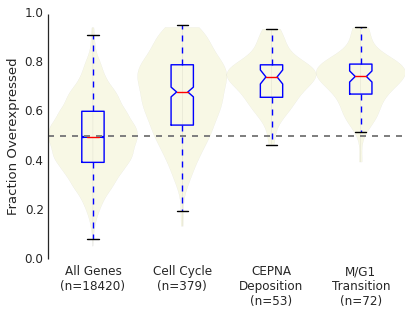

In [10]:
fig, ax = subplots()
v = pd.concat([dx_rna.frac, 
               dx_rna.frac.ix[ti(gs2['REACTOME_CELL_CYCLE']>0)],
               dx_rna.frac.ix[ti(gs2[m_g1]>0)],
               dx_rna.frac.ix[ti(gs2[cepna]>0)]
               ]).dropna()
v1 = pd.concat([pd.Series('All Genes', dx_rna.frac.index), 
                pd.Series('Cell Cycle', ti(gs2['REACTOME_CELL_CYCLE']>0)),
                pd.Series('M/G1\nTransition', ti(gs2[m_g1]>0)),
                pd.Series('CEPNA\nDeposition', ti(gs2[cepna]>0))
                ])
v1.name = ''
v.name = 'Fraction Overexpressed'
o = ['All Genes','Cell Cycle','CEPNA\nDeposition',
     'M/G1\nTransition']
violin_plot_pandas(v1, v, order=o, ann=None, ax=ax)
prettify_ax(ax)
ax.spines['bottom'].set_visible(False)
ax.axhline(.5, color='grey', lw=2, ls='--');

I can also change the greedy filter to look for gene-sets with large effect sizes as opposed to p-values. This is going to give us smaller, but more specific gene-sets. 

In [11]:
f2 = fp.ix[ti(rr.q < .00001)]
ff_u = filter_pathway_hits(fp.ix[ti(f2>.5)].order()[::-1], gs2)
ff_p = filter_pathway_hits(fp.ix[ti(f2<.5)].order(), gs2)
ff = ff_u.append(ff_p)

selected = rr.ix[ff.index].join(f2)
selected.ix[(f2 - .5).abs().order().index[::-1]].dropna()

,H,p,q,mean frac
REACTOME_UNWINDING_OF_DNA,28.36,1.01e-07,9.71e-07,0.81
REACTOME_EXTENSION_OF_TELOMERES,54.89,1.27e-13,2.17e-12,0.75
REACTOME_DEPOSITION_OF_NEW_CENPA_CONTAINING_NUCLEOSOMES_AT_THE_CENTROMERE,101.96,5.65e-24,3.13e-22,0.74
BIOCARTA_PROTEASOME_PATHWAY,55.43,9.70e-14,1.72e-12,0.73
REACTOME_FANCONI_ANEMIA_PATHWAY,30.10,4.11e-08,4.14e-07,0.70
PID_FOXM1_PATHWAY,34.39,4.51e-09,5.13e-08,0.69
REACTOME_CYTOSOLIC_TRNA_AMINOACYLATION,33.38,7.60e-09,8.49e-08,0.69
REACTOME_MRNA_SPLICING_MINOR_PATHWAY,50.54,1.17e-12,1.78e-11,0.68
KEGG_FATTY_ACID_METABOLISM,47.58,5.28e-12,7.63e-11,0.32
REACTOME_NEP_NS2_INTERACTS_WITH_THE_CELLULAR_EXPORT_MACHINERY,32.01,1.53e-08,1.67e-07,0.66


Interestingly unwinding of DNA has a very large effect size but is a relatviely small gene set at only 11 genes. 

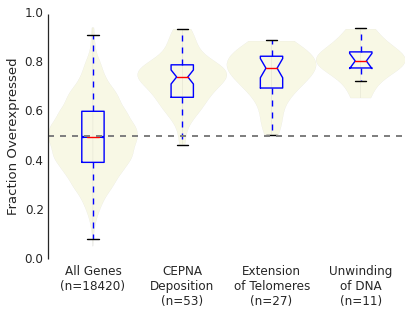

In [15]:
unwind = 'REACTOME_UNWINDING_OF_DNA'
telo = 'REACTOME_EXTENSION_OF_TELOMERES'

fig, ax = subplots()
v = pd.concat([dx_rna.frac, 
               dx_rna.frac.ix[ti(gs2[cepna]>0)],
               dx_rna.frac.ix[ti(gs2[unwind]>0)],
               dx_rna.frac.ix[ti(gs2[telo]>0)]
               ]).dropna()
v1 = pd.concat([pd.Series('All Genes', dx_rna.frac.index), 
                pd.Series('CEPNA\nDeposition', ti(gs2[cepna]>0)),
                pd.Series('Unwinding\nof DNA', ti(gs2[unwind]>0)),
                pd.Series('Extension\nof Telomeres', ti(gs2[telo]>0))
                ])
v1.name = ''
v.name = 'Fraction Overexpressed'
o = ['All Genes', 'CEPNA\nDeposition',
     'Extension\nof Telomeres', 'Unwinding\nof DNA', ]
violin_plot_pandas(v1, v, order=o, ann=None, ax=ax)
prettify_ax(ax)
ax.spines['bottom'].set_visible(False)
ax.axhline(.5, color='grey', lw=2, ls='--');